In [1]:
import os, cv2, glob, sys
import numpy as np
import matplotlib.pyplot as plt
from keras.models import load_model
from tqdm  import tqdm
from datetime import datetime

import tensorflow as tf

# Add the upper level directory to the path
sys.path.append('..')
import imutils as im
sys.path.append('../Preprocessing')
from preproc import beautify_frame

8 images loaded
Type of images:  <class 'numpy.ndarray'>


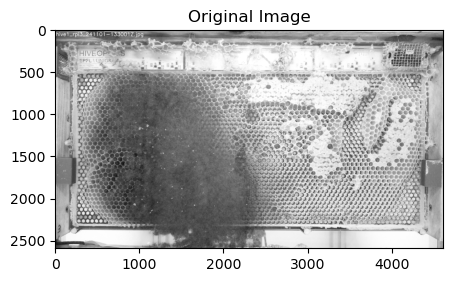

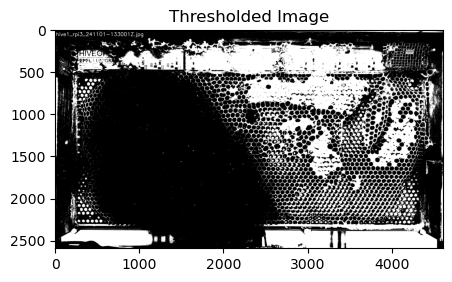

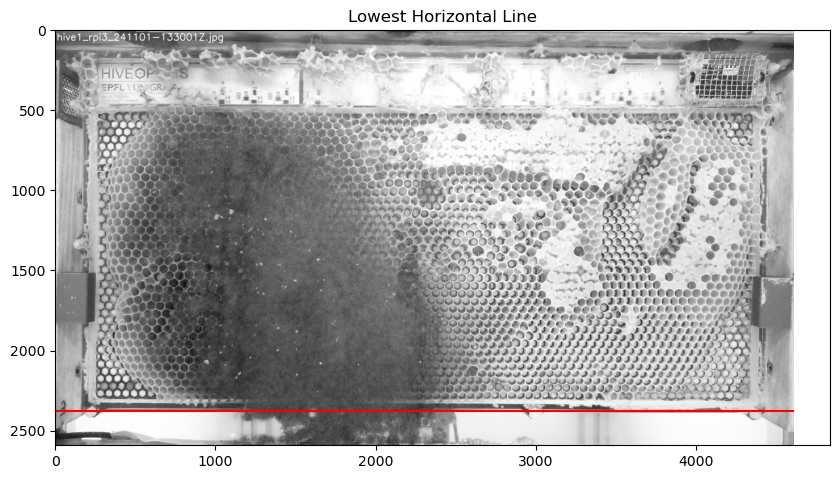

In [28]:
# Load the images in ../ForegroundRemoval/iLastikDataset
images = glob.glob('../ForegroundRemoval/iLastikDataset/*.png')
images = sorted(images)
images = [cv2.imread(img, cv2.IMREAD_GRAYSCALE) for img in images] 

print(len(images), 'images loaded')
print("Type of images: ", type(images[0]))


# Show the first image
plt.figure(figsize=(5,5))
plt.imshow(images[0], cmap='gray')
plt.title('Original Image')
plt.show()


def thresholding(img, threshold):
    # Apply a threshold to the image
    _, img = cv2.threshold(img, threshold, 255, cv2.THRESH_BINARY)
    return img


th_img = thresholding(images[0], 200)
plt.figure(figsize=(5,5))
plt.imshow(th_img, cmap='gray')
plt.title('Thresholded Image')
plt.show()


# Perform edge detection
edges = cv2.Canny(images[0], 350, 450)
# Detect lines using Hough Transform
lines = cv2.HoughLinesP(edges, 1, np.pi / 180, threshold=50, minLineLength=2600, maxLineGap=1500)
h_lines = [line for line in lines if abs(line[0][1] - line[0][3]) < 80] # Horizontal lines

if len(h_lines) == 0:
    raise ValueError("No horizontal lines detected")


lowest_h_line = h_lines[np.argmax([line[0][1] for line in h_lines])]

upper_shift = np.mean([lowest_h_line[0][1], lowest_h_line[0][3]])

# Show the lowest horizontal line
plt.figure(figsize=(10,10))
plt.imshow(images[0], cmap='gray')
plt.plot([0, images[0].shape[1]], [upper_shift, upper_shift], 'r')
plt.title('Lowest Horizontal Line')
plt.show()

In [11]:
root_path = '/Users/cyrilmonette/Library/CloudStorage/SynologyDrive-data/'

folders = [ '24.09-24.10_observation_OH',
            '24.11_aSensing_OH',
            '24.11-25.01_metabolism_OH']

# Those folders contain a subfolder called Images, itself containing hxry folders (x<=2, y<=4). From all those folders, load 3 random images
images = []
for folder in folders:
    subfolders = os.listdir(root_path + folder + '/Images')
    # Only keep subfolders that start with h
    subfolders = [sf for sf in subfolders if sf[0] == 'h']
    for subfolder in tqdm(subfolders, desc="Subfolders"):
        imgs = os.listdir(root_path + folder + '/Images/' + subfolder)
        # Pick 2 random images from the subfolder
        random_imgs = np.random.choice(imgs, 2)
        print(random_imgs)
        for img in random_imgs:
            images.append(cv2.imread(root_path + folder + '/Images/' + subfolder + '/' + img, cv2.IMREAD_GRAYSCALE))

Subfolders:   0%|          | 0/8 [00:00<?, ?it/s]

['hive2_rpi2_241015-150101Z.jpg' 'hive2_rpi2_241020-151001Z.jpg']


Subfolders:   0%|          | 0/8 [00:29<?, ?it/s]


KeyboardInterrupt: 

In [ ]:
def compute_pixel_shifts(image):
        '''
        Computes the pixel shifts between the thermal and the imaging data, for every image of the hive.
        Returns a list of 4 tuples, each tuple containing the x,y shifts for the corresponding RPi image.
        '''
        shifts = []
        if self.pp_imgs is None:
            # Preprocess images with Preprocessing library
            self.pp_imgs = []
            for img in self.imgs:
                gray_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
                self.pp_imgs.append(beautify_frame(gray_img))

        for pp_img in self.pp_imgs:
            # Perform edge detection
            edges = cv2.Canny(pp_img, 350, 450)
            # Detect lines using Hough Transform
            lines = cv2.HoughLinesP(edges, 1, np.pi / 180, threshold=50, minLineLength=3500, maxLineGap=1000)
            h_lines = [line for line in lines if abs(line[0][1] - line[0][3]) < 20] # Horizontal lines
            v_lines = [line for line in lines if abs(line[0][0] - line[0][2]) < 20] # Vertical lines
            # Discard the v_lines that are too close to the left border
            if v_lines is not None:
                v_lines = [line for line in v_lines if line[0][0] > 10]

            if len(h_lines) == 0:
                raise ValueError("No horizontal lines detected")
            if len(v_lines) == 0:
                raise ValueError("No vertical lines detected")
            
            lowest_h_line = h_lines[np.argmax([line[0][1] for line in h_lines])]
            leftest_v_line = v_lines[np.argmin([line[0][0] for line in v_lines])]

            upper_shift = np.mean([lowest_h_line[0][1], lowest_h_line[0][3]])
            left_shift = np.mean([leftest_v_line[0][0], leftest_v_line[0][2]])
            shifts.append((left_shift, upper_shift))
        
        self.thermal_shifts = shifts
        return self.thermal_shifts